In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import Optimizer
import torch.backends.cudnn as cudnn
import tqdm

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader,Subset
import torchvision.models as models
import torch.nn.functional as F

import sys
import os
sys.path.append(os.path.abspath(".."))
from models import *
import copy
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from util import *

random_seed = 0
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)

torch.cuda.set_device(0)
device = 'cuda'
dataset_path = '/narcissus/dataset/'

In [3]:
import os
import torchvision
import torchvision.transforms as transforms

dataset_path = os.path.expanduser("~/datasets/")
cifar10_path = os.path.join(dataset_path, "cifar-10-batches-py")

if not os.path.exists(cifar10_path):
    print("Downloading CIFAR-10...")
    torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=True)
    torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=True)
else:
    print("CIFAR-10 already downloaded.")


CIFAR-10 already downloaded.


In [4]:
import os
import urllib.request
import zipfile

tiny_imagenet_dir = os.path.join(dataset_path, "tiny-imagenet-200")

if not os.path.exists(tiny_imagenet_dir):
    print("Downloading Tiny ImageNet...")
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    zip_path = os.path.join(dataset_path, "tiny-imagenet-200.zip")
    
    urllib.request.urlretrieve(url, zip_path)

    print("Extracting Tiny ImageNet...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_path)
    
    os.remove(zip_path)
    print("Done.")
else:
    print("Tiny ImageNet already downloaded.")


Tiny ImageNet already downloaded.


In [5]:
'''
The path for target dataset and public out-of-distribution (POOD) dataset. The setting used 
here is CIFAR-10 as the target dataset and Tiny-ImageNet as the POOD dataset. Their directory
structure is as follows:

dataset_path--cifar-10-batches-py
            |
            |-tiny-imagenet-200
'''
# dataset_path = '/home/minzhou/data/'

#The target class label
lab = 2

#Noise size, default is full image size
noise_size = 32

#Radius of the L-inf ball
l_inf_r = 16/255

#Model for generating surrogate model and trigger
surrogate_model = ResNet18_201().cuda()
generating_model = ResNet18_201().cuda()

#Surrogate model training epochs
surrogate_epochs = 200

#Learning rate for poison-warm-up
generating_lr_warmup = 0.1
warmup_round = 5

#Learning rate for trigger generating
generating_lr_tri = 0.01      
gen_round = 1000

#Training batch size
train_batch_size = 350

#The model for adding the noise
patch_mode = 'add'

# Prepare dataset

In [6]:
#The argumention use for surrogate model training stage
transform_surrogate_train = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#The argumention use for all training set
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#The argumention use for all testing set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [7]:
ori_train = torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=False, transform=transform_train)
ori_test = torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=False, transform=transform_test)
outter_trainset = torchvision.datasets.ImageFolder(root=dataset_path + 'tiny-imagenet-200/train/', transform=transform_surrogate_train)

In [8]:
#Outter train dataset
train_label = [get_labels(ori_train)[x] for x in range(len(get_labels(ori_train)))]
test_label = [get_labels(ori_test)[x] for x in range(len(get_labels(ori_test)))]

In [9]:
#Inner train dataset
train_target_list = list(np.where(np.array(train_label)==lab)[0])
train_target = Subset(ori_train,train_target_list)

In [10]:
concoct_train_dataset = concoct_dataset(train_target,outter_trainset)

In [11]:
surrogate_loader = torch.utils.data.DataLoader(concoct_train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=16)

poi_warm_up_loader = torch.utils.data.DataLoader(train_target, batch_size=train_batch_size, shuffle=True, num_workers=16)

trigger_gen_loaders = torch.utils.data.DataLoader(train_target, batch_size=train_batch_size, shuffle=True, num_workers=16)

#  Training surrogate modle

In [12]:
# Batch_grad
condition = True
noise = torch.zeros((1, 3, noise_size, noise_size), device=device)


surrogate_model = surrogate_model
criterion = torch.nn.CrossEntropyLoss()
# outer_opt = torch.optim.RAdam(params=base_model.parameters(), lr=generating_lr_outer)
surrogate_opt = torch.optim.SGD(params=surrogate_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
surrogate_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(surrogate_opt, T_max=surrogate_epochs)

In [13]:
save_path = 'surrogate_pretrain_' + str(surrogate_epochs) +'.pth'

if os.path.exists(save_path):
    print(f"Loading pre-trained surrogate model from {save_path}")
    surrogate_model.load_state_dict(torch.load(save_path))
else:
    print('Training the surrogate model')
    for epoch in range(0, surrogate_epochs):
        surrogate_model.train()
        loss_list = []
        for images, labels in surrogate_loader:
            images, labels = images.cuda(), labels.cuda()
            surrogate_opt.zero_grad()
            outputs = surrogate_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            loss_list.append(float(loss.data))
            surrogate_opt.step()
        surrogate_scheduler.step()
        ave_loss = np.average(np.array(loss_list))
        print('Epoch:%d, Loss: %.03f' % (epoch, ave_loss))
    
    torch.save(surrogate_model.state_dict(), save_path)


Training the surrogate model
Epoch:0, Loss: 4.621
Epoch:1, Loss: 3.893
Epoch:2, Loss: 3.407
Epoch:3, Loss: 3.074
Epoch:4, Loss: 2.832
Epoch:5, Loss: 2.634
Epoch:6, Loss: 2.481
Epoch:7, Loss: 2.368
Epoch:8, Loss: 2.273
Epoch:9, Loss: 2.186
Epoch:10, Loss: 2.128
Epoch:11, Loss: 2.066
Epoch:12, Loss: 2.005
Epoch:13, Loss: 1.959
Epoch:14, Loss: 1.914
Epoch:15, Loss: 1.875
Epoch:16, Loss: 1.837
Epoch:17, Loss: 1.801
Epoch:18, Loss: 1.774
Epoch:19, Loss: 1.739
Epoch:20, Loss: 1.718
Epoch:21, Loss: 1.687
Epoch:22, Loss: 1.667
Epoch:23, Loss: 1.640
Epoch:24, Loss: 1.622
Epoch:25, Loss: 1.610
Epoch:26, Loss: 1.584
Epoch:27, Loss: 1.556
Epoch:28, Loss: 1.543
Epoch:29, Loss: 1.521
Epoch:30, Loss: 1.503
Epoch:31, Loss: 1.489
Epoch:32, Loss: 1.480
Epoch:33, Loss: 1.459
Epoch:34, Loss: 1.443
Epoch:35, Loss: 1.435
Epoch:36, Loss: 1.427
Epoch:37, Loss: 1.406
Epoch:38, Loss: 1.390
Epoch:39, Loss: 1.381
Epoch:40, Loss: 1.365
Epoch:41, Loss: 1.347
Epoch:42, Loss: 1.341
Epoch:43, Loss: 1.336
Epoch:44, Los

# Poison warm up

In [ ]:
def lowpass_projection(tensor, cutoff_ratio=0.2):
    
    _, C, H, W = tensor.shape
    projected = torch.zeros_like(tensor)

    cutoff_H = int(H * cutoff_ratio)
    cutoff_W = int(W * cutoff_ratio)

    for ch in range(C):
        fft2 = torch.fft.fft2(tensor[0, ch])
        fft2_shift = torch.fft.fftshift(fft2)
    
        mask = torch.zeros_like(fft2_shift)
        center_H = H // 2
        center_W = W // 2
        mask[center_H - cutoff_H:center_H + cutoff_H, center_W - cutoff_W:center_W + cutoff_W] = 1
        fft2_low = fft2_shift * mask

        lowpass = torch.fft.ifft2(torch.fft.ifftshift(fft2_low)).real
        projected[0, ch] = lowpass

    return projected


In [15]:
#cell 13
#Prepare models and optimizers for poi_warm_up training
poi_warm_up_model = generating_model
poi_warm_up_model.load_state_dict(surrogate_model.state_dict())

poi_warm_up_opt = torch.optim.RAdam(params=poi_warm_up_model.parameters(), lr=generating_lr_warmup)

In [16]:
#cell 14
#Poi_warm_up stage
poi_warm_up_model.train()
for param in poi_warm_up_model.parameters():
    param.requires_grad = True

#Training the surrogate model
for epoch in range(0, warmup_round):
    poi_warm_up_model.train()
    loss_list = []
    for images, labels in poi_warm_up_loader:
        images, labels = images.cuda(), labels.cuda()
        poi_warm_up_model.zero_grad()
        poi_warm_up_opt.zero_grad()
        outputs = poi_warm_up_model(images)
        loss = criterion(outputs, labels)
        loss.backward(retain_graph = True)
        loss_list.append(float(loss.data))
        poi_warm_up_opt.step()
    ave_loss = np.average(np.array(loss_list))
    print('Epoch:%d, Loss: %e' % (epoch, ave_loss))

Epoch:0, Loss: 5.462804e-01
Epoch:1, Loss: 2.772788e-05
Epoch:2, Loss: 3.588172e-06
Epoch:3, Loss: 1.779734e-06
Epoch:4, Loss: 1.346358e-06


# Trigger generating

  0%|          | 0/1000 [00:00<?, ?it/s]

Gradient: 4.3833337e-05 Loss: 1.1198047180490297e-06
Gradient: 3.1628308e-05 Loss: 1.115921916531685e-06
Gradient: 5.5022894e-05 Loss: 1.0420353684518583e-06
Gradient: 2.1033062e-05 Loss: 1.061698981175141e-06
Gradient: 6.8299276e-05 Loss: 1.0012314760388107e-06
Gradient: 1.8352035e-05 Loss: 1.5417702210622034e-06
Gradient: 5.8818958e-05 Loss: 1.2565661525817026e-06
Gradient: 6.475031e-05 Loss: 1.2027745526665967e-06
Gradient: 3.6721693e-05 Loss: 1.1913302917794984e-06
Gradient: 1.29855935e-05 Loss: 1.4630583403156075e-06
Gradient: 4.350487e-05 Loss: 1.2007194811758382e-06
Gradient: 6.4830474e-06 Loss: 8.67762828230904e-07
Gradient: 4.7391157e-05 Loss: 1.3288400566580094e-06
Gradient: 3.439473e-05 Loss: 1.1048636376168968e-06
Gradient: 1.4469063e-05 Loss: 1.1632763071626564e-06
Gradient: 4.292923e-05 Loss: 1.258915790458559e-06
Gradient: 4.9036178e-05 Loss: 1.027287244899829e-06
Gradient: 1.5437443e-05 Loss: 1.056635365633459e-06
Gradient: 6.015817e-05 Loss: 1.1382310541800203e-06
Grad

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.20116186..0.20269516].


Gradient: 4.1247616e-10 Loss: 7.067963887645116e-07


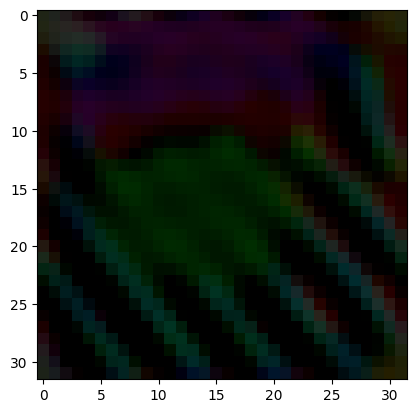

Noise max val: tensor(0.2027, device='cuda:0', grad_fn=<MaxBackward1>)


In [17]:
#cell 15
from tqdm.notebook import tqdm

#Trigger generating stage
for param in poi_warm_up_model.parameters():
    param.requires_grad = False

batch_pert = torch.autograd.Variable(noise.cuda(), requires_grad=True)
batch_opt = torch.optim.RAdam(params=[batch_pert],lr=generating_lr_tri)
for minmin in tqdm(range(gen_round)):
    loss_list = []
    for images, labels in trigger_gen_loaders:
        images, labels = images.cuda(), labels.cuda()
        new_images = torch.clone(images)
        # clamp_batch_pert = torch.clamp(batch_pert,-l_inf_r*2,l_inf_r*2)
        clamp_batch_pert = torch.clamp(batch_pert, -l_inf_r*2, l_inf_r*2)
        clamp_batch_pert = lowpass_projection(clamp_batch_pert, cutoff_ratio=0.2)
        new_images = torch.clamp(apply_noise_patch(clamp_batch_pert,new_images.clone(),mode=patch_mode),-1,1)
        per_logits = poi_warm_up_model.forward(new_images)
        loss = criterion(per_logits, labels)
        loss_regu = torch.mean(loss)
        batch_opt.zero_grad()
        loss_list.append(float(loss_regu.data))
        loss_regu.backward(retain_graph = True)
        batch_opt.step()
    ave_loss = np.average(np.array(loss_list))
    ave_grad = np.sum(abs(batch_pert.grad).detach().cpu().numpy())
    print('Gradient:',ave_grad,'Loss:', ave_loss)
    if ave_grad == 0:
        break

# noise = torch.clamp(batch_pert,-l_inf_r*2,l_inf_r*2)
clamp_final = torch.clamp(batch_pert, -l_inf_r*2, l_inf_r*2)
noise = lowpass_projection(clamp_final, cutoff_ratio=0.2)
best_noise = noise.clone().detach().cpu()
plt.imshow(np.transpose(noise[0].detach().cpu(),(1,2,0)))
plt.show()
print('Noise max val:',noise.max())

In [18]:
#cell 16
#Save the trigger
import time
save_name = 'best_noise'+'_'+ time.strftime("%m-%d-%H_%M_%S",time.localtime(time.time())) 
np.save(save_name, best_noise)

# Testing  attack effect

In [20]:
#cell 17
#Using this block if you only want to test the attack result.
save_name = 'best_noise.npy'
import imageio
import cv2 as cv
best_noise = torch.zeros((1, 3, noise_size, noise_size), device=device)
noise_npy = np.load(save_name)

best_noise = torch.from_numpy(noise_npy)
if best_noise.dim() == 3:
    best_noise = best_noise.unsqueeze(0)
best_noise = best_noise.cuda()
# best_noise = fft_lowpass_trigger(best_noise, cutoff_ratio=0.2)


In [21]:
#cell 18
#Poisoning amount use for the target class
poison_amount = 25

#Model uses for testing
noise_testing_model = ResNet18().cuda()    

#Training parameters
training_epochs = 200
training_lr = 0.1
test_batch_size = 150

#The multiple of noise amplification during testing
multi_test = 3

#random seed for testing stage
random_seed = 65

In [22]:
# cell 19
import torchvision.models as models
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)
model = noise_testing_model

optimizer = torch.optim.SGD(params=model.parameters(), lr=training_lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=training_epochs)

In [23]:
# cell 20
transform_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
poi_ori_train = torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=False, transform=transform_tensor)
poi_ori_test = torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=False, transform=transform_tensor)
transform_after_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(),
])

In [24]:
#cell 21
#Poison traing
random_poison_idx = random.sample(train_target_list, poison_amount)
poison_train_target = poison_image(poi_ori_train,random_poison_idx,best_noise.cpu(),transform_after_train)
print('Traing dataset size is:',len(poison_train_target)," Poison numbers is:",len(random_poison_idx))
clean_train_loader = DataLoader(poison_train_target, batch_size=test_batch_size, shuffle=True, num_workers=2)

Traing dataset size is: 50000  Poison numbers is: 25


In [25]:
#cell 22
#Attack success rate testing
test_non_target = list(np.where(np.array(test_label)!=lab)[0])
test_non_target_change_image_label = poison_image_label(poi_ori_test,test_non_target,best_noise.cpu()*multi_test,lab,None)
asr_loaders = torch.utils.data.DataLoader(test_non_target_change_image_label, batch_size=test_batch_size, shuffle=True, num_workers=2)
print('Poison test dataset size is:',len(test_non_target_change_image_label))

Poison test dataset size is: 9000


In [26]:
#cell 23
#Clean acc test dataset
clean_test_loader = torch.utils.data.DataLoader(ori_test, batch_size=test_batch_size, shuffle=False, num_workers=2)

In [27]:
#cell 24
#Target clean test dataset
test_target = list(np.where(np.array(test_label)==lab)[0])
target_test_set = Subset(ori_test,test_target)
target_test_loader = torch.utils.data.DataLoader(target_test_set, batch_size=test_batch_size, shuffle=True, num_workers=2)

In [28]:
#cell 25
from util import AverageMeter
train_ACC = []
test_ACC = []
clean_ACC = []
target_ACC = []

In [30]:
#cell 26
for epoch in tqdm(range(training_epochs)):
    # Train
    model.train()
    acc_meter = AverageMeter()
    loss_meter = AverageMeter()
    pbar = tqdm(clean_train_loader, total=len(clean_train_loader))
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        model.zero_grad()
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(logits.data, 1)
        acc = (predicted == labels).sum().item()/labels.size(0)
        acc_meter.update(acc)
        loss_meter.update(loss.item())
        pbar.set_description("Acc %.2f Loss: %.2f" % (acc_meter.avg*100, loss_meter.avg))
    train_ACC.append(acc_meter.avg)
    print('Train_loss:',loss)
    scheduler.step()
    
    # Testing attack effect
    model.eval()
    correct, total = 0, 0
    for i, (images, labels) in enumerate(asr_loaders):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            logits = model(images)
            out_loss = criterion(logits,labels)
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    test_ACC.append(acc)
    print('\nAttack success rate %.2f' % (acc*100))
    print('Test_loss:',out_loss)
    
    correct_clean, total_clean = 0, 0
    for i, (images, labels) in enumerate(clean_test_loader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            logits = model(images)
            out_loss = criterion(logits,labels)
            _, predicted = torch.max(logits.data, 1)
            total_clean += labels.size(0)
            correct_clean += (predicted == labels).sum().item()
    acc_clean = correct_clean / total_clean
    clean_ACC.append(acc_clean)
    print('\nTest clean Accuracy %.2f' % (acc_clean*100))
    print('Test_loss:',out_loss)
    
    correct_tar, total_tar = 0, 0
    for i, (images, labels) in enumerate(target_test_loader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            logits = model(images)
            out_loss = criterion(logits,labels)
            _, predicted = torch.max(logits.data, 1)
            total_tar += labels.size(0)
            correct_tar += (predicted == labels).sum().item()
    acc_tar = correct_tar / total_tar
    target_ACC.append(acc_tar)
    print('\nTarget test clean Accuracy %.2f' % (acc_tar*100))
    print('Test_loss:',out_loss)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(1.8523, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.01
Test_loss: tensor(2.8346, device='cuda:0')

Test clean Accuracy 39.74
Test_loss: tensor(1.6209, device='cuda:0')

Target test clean Accuracy 3.10
Test_loss: tensor(2.2280, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(1.3651, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.00
Test_loss: tensor(5.3945, device='cuda:0')

Test clean Accuracy 47.28
Test_loss: tensor(1.5662, device='cuda:0')

Target test clean Accuracy 14.00
Test_loss: tensor(2.5390, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(1.1334, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.32
Test_loss: tensor(4.4043, device='cuda:0')

Test clean Accuracy 55.79
Test_loss: tensor(1.2505, device='cuda:0')

Target test clean Accuracy 34.50
Test_loss: tensor(1.7126, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(1.0050, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.08
Test_loss: tensor(5.3483, device='cuda:0')

Test clean Accuracy 63.09
Test_loss: tensor(1.1140, device='cuda:0')

Target test clean Accuracy 46.60
Test_loss: tensor(1.4330, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.8149, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 18.46
Test_loss: tensor(2.2300, device='cuda:0')

Test clean Accuracy 65.61
Test_loss: tensor(0.9172, device='cuda:0')

Target test clean Accuracy 65.30
Test_loss: tensor(0.7850, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.6547, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.12
Test_loss: tensor(3.4141, device='cuda:0')

Test clean Accuracy 67.69
Test_loss: tensor(0.9533, device='cuda:0')

Target test clean Accuracy 45.70
Test_loss: tensor(1.8381, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.6686, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.89
Test_loss: tensor(3.3718, device='cuda:0')

Test clean Accuracy 73.47
Test_loss: tensor(0.7247, device='cuda:0')

Target test clean Accuracy 60.80
Test_loss: tensor(1.1473, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.6321, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 3.59
Test_loss: tensor(3.3087, device='cuda:0')

Test clean Accuracy 76.75
Test_loss: tensor(0.6936, device='cuda:0')

Target test clean Accuracy 72.30
Test_loss: tensor(0.9371, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5407, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 16.08
Test_loss: tensor(2.2730, device='cuda:0')

Test clean Accuracy 76.26
Test_loss: tensor(0.5945, device='cuda:0')

Target test clean Accuracy 75.10
Test_loss: tensor(0.7443, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5188, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 33.73
Test_loss: tensor(1.7384, device='cuda:0')

Test clean Accuracy 78.38
Test_loss: tensor(0.6646, device='cuda:0')

Target test clean Accuracy 65.80
Test_loss: tensor(1.0072, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.7294, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 4.24
Test_loss: tensor(2.6820, device='cuda:0')

Test clean Accuracy 75.33
Test_loss: tensor(0.6360, device='cuda:0')

Target test clean Accuracy 74.70
Test_loss: tensor(0.5623, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5883, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 6.28
Test_loss: tensor(3.4227, device='cuda:0')

Test clean Accuracy 79.05
Test_loss: tensor(0.7273, device='cuda:0')

Target test clean Accuracy 70.80
Test_loss: tensor(0.6555, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5717, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.08
Test_loss: tensor(2.9180, device='cuda:0')

Test clean Accuracy 80.78
Test_loss: tensor(0.5209, device='cuda:0')

Target test clean Accuracy 62.60
Test_loss: tensor(1.1859, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5295, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.99
Test_loss: tensor(4.5624, device='cuda:0')

Test clean Accuracy 82.88
Test_loss: tensor(0.6695, device='cuda:0')

Target test clean Accuracy 75.80
Test_loss: tensor(0.6454, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5921, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 26.86
Test_loss: tensor(2.0633, device='cuda:0')

Test clean Accuracy 81.87
Test_loss: tensor(0.5212, device='cuda:0')

Target test clean Accuracy 68.90
Test_loss: tensor(0.9475, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4584, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 9.10
Test_loss: tensor(2.5130, device='cuda:0')

Test clean Accuracy 81.50
Test_loss: tensor(0.4755, device='cuda:0')

Target test clean Accuracy 79.90
Test_loss: tensor(0.4500, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3835, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 8.03
Test_loss: tensor(2.3895, device='cuda:0')

Test clean Accuracy 80.05
Test_loss: tensor(0.5876, device='cuda:0')

Target test clean Accuracy 83.10
Test_loss: tensor(0.3855, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.6396, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 10.91
Test_loss: tensor(2.9133, device='cuda:0')

Test clean Accuracy 82.76
Test_loss: tensor(0.4678, device='cuda:0')

Target test clean Accuracy 74.90
Test_loss: tensor(0.9297, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5754, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 58.56
Test_loss: tensor(0.8990, device='cuda:0')

Test clean Accuracy 82.19
Test_loss: tensor(0.5275, device='cuda:0')

Target test clean Accuracy 81.00
Test_loss: tensor(0.4573, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.7602, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 53.99
Test_loss: tensor(1.6872, device='cuda:0')

Test clean Accuracy 79.30
Test_loss: tensor(0.5234, device='cuda:0')

Target test clean Accuracy 81.80
Test_loss: tensor(0.6627, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.7415, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 16.18
Test_loss: tensor(3.1514, device='cuda:0')

Test clean Accuracy 82.07
Test_loss: tensor(0.5998, device='cuda:0')

Target test clean Accuracy 65.20
Test_loss: tensor(1.0045, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4605, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 52.08
Test_loss: tensor(1.7918, device='cuda:0')

Test clean Accuracy 83.36
Test_loss: tensor(0.6016, device='cuda:0')

Target test clean Accuracy 77.90
Test_loss: tensor(0.6729, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4064, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.50
Test_loss: tensor(3.8053, device='cuda:0')

Test clean Accuracy 84.64
Test_loss: tensor(0.4185, device='cuda:0')

Target test clean Accuracy 65.20
Test_loss: tensor(0.8269, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3501, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.89
Test_loss: tensor(2.9611, device='cuda:0')

Test clean Accuracy 83.74
Test_loss: tensor(0.4123, device='cuda:0')

Target test clean Accuracy 82.60
Test_loss: tensor(0.3438, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2567, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 6.52
Test_loss: tensor(2.3617, device='cuda:0')

Test clean Accuracy 85.33
Test_loss: tensor(0.3981, device='cuda:0')

Target test clean Accuracy 84.50
Test_loss: tensor(0.3560, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4341, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 4.20
Test_loss: tensor(3.2028, device='cuda:0')

Test clean Accuracy 79.14
Test_loss: tensor(0.5830, device='cuda:0')

Target test clean Accuracy 80.70
Test_loss: tensor(0.4752, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0777, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 5.30
Test_loss: tensor(3.2285, device='cuda:0')

Test clean Accuracy 83.83
Test_loss: tensor(0.5465, device='cuda:0')

Target test clean Accuracy 87.10
Test_loss: tensor(0.4840, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4665, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 6.11
Test_loss: tensor(2.9516, device='cuda:0')

Test clean Accuracy 83.34
Test_loss: tensor(0.4518, device='cuda:0')

Target test clean Accuracy 78.90
Test_loss: tensor(0.7739, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3858, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 40.12
Test_loss: tensor(1.5405, device='cuda:0')

Test clean Accuracy 80.95
Test_loss: tensor(0.5874, device='cuda:0')

Target test clean Accuracy 88.70
Test_loss: tensor(0.2563, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4218, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 52.54
Test_loss: tensor(1.5005, device='cuda:0')

Test clean Accuracy 83.88
Test_loss: tensor(0.4342, device='cuda:0')

Target test clean Accuracy 79.40
Test_loss: tensor(0.7491, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5362, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 69.40
Test_loss: tensor(1.0778, device='cuda:0')

Test clean Accuracy 81.89
Test_loss: tensor(0.5670, device='cuda:0')

Target test clean Accuracy 73.00
Test_loss: tensor(0.7141, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2935, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 8.68
Test_loss: tensor(2.7636, device='cuda:0')

Test clean Accuracy 85.56
Test_loss: tensor(0.2965, device='cuda:0')

Target test clean Accuracy 78.40
Test_loss: tensor(0.5989, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3249, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 6.02
Test_loss: tensor(3.4252, device='cuda:0')

Test clean Accuracy 79.57
Test_loss: tensor(0.5284, device='cuda:0')

Target test clean Accuracy 80.70
Test_loss: tensor(0.6411, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5356, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.61
Test_loss: tensor(3.2450, device='cuda:0')

Test clean Accuracy 85.12
Test_loss: tensor(0.4370, device='cuda:0')

Target test clean Accuracy 81.30
Test_loss: tensor(0.6314, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3003, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 16.63
Test_loss: tensor(2.2168, device='cuda:0')

Test clean Accuracy 85.52
Test_loss: tensor(0.5738, device='cuda:0')

Target test clean Accuracy 82.40
Test_loss: tensor(0.2536, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2421, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 6.22
Test_loss: tensor(3.5200, device='cuda:0')

Test clean Accuracy 80.97
Test_loss: tensor(0.5837, device='cuda:0')

Target test clean Accuracy 63.10
Test_loss: tensor(1.1047, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3878, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 36.49
Test_loss: tensor(1.5618, device='cuda:0')

Test clean Accuracy 83.05
Test_loss: tensor(0.5231, device='cuda:0')

Target test clean Accuracy 83.00
Test_loss: tensor(0.6405, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3366, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 12.30
Test_loss: tensor(2.2730, device='cuda:0')

Test clean Accuracy 87.21
Test_loss: tensor(0.2892, device='cuda:0')

Target test clean Accuracy 84.50
Test_loss: tensor(0.3817, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1464, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 11.88
Test_loss: tensor(2.6882, device='cuda:0')

Test clean Accuracy 82.47
Test_loss: tensor(0.3858, device='cuda:0')

Target test clean Accuracy 74.60
Test_loss: tensor(0.8897, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4096, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 29.67
Test_loss: tensor(2.1262, device='cuda:0')

Test clean Accuracy 79.78
Test_loss: tensor(0.4134, device='cuda:0')

Target test clean Accuracy 76.30
Test_loss: tensor(0.6440, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5882, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 38.84
Test_loss: tensor(2.0629, device='cuda:0')

Test clean Accuracy 84.52
Test_loss: tensor(0.4389, device='cuda:0')

Target test clean Accuracy 88.60
Test_loss: tensor(0.2477, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4231, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 53.08
Test_loss: tensor(1.2963, device='cuda:0')

Test clean Accuracy 85.75
Test_loss: tensor(0.4511, device='cuda:0')

Target test clean Accuracy 89.10
Test_loss: tensor(0.2070, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2523, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 53.78
Test_loss: tensor(1.2563, device='cuda:0')

Test clean Accuracy 84.95
Test_loss: tensor(0.5883, device='cuda:0')

Target test clean Accuracy 82.30
Test_loss: tensor(0.5310, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4707, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 13.22
Test_loss: tensor(2.1931, device='cuda:0')

Test clean Accuracy 84.47
Test_loss: tensor(0.3710, device='cuda:0')

Target test clean Accuracy 79.80
Test_loss: tensor(0.5577, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2937, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 47.63
Test_loss: tensor(1.1561, device='cuda:0')

Test clean Accuracy 82.17
Test_loss: tensor(0.3577, device='cuda:0')

Target test clean Accuracy 93.80
Test_loss: tensor(0.3595, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2965, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 35.82
Test_loss: tensor(2.1589, device='cuda:0')

Test clean Accuracy 87.57
Test_loss: tensor(0.3873, device='cuda:0')

Target test clean Accuracy 79.90
Test_loss: tensor(0.6836, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2002, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 10.41
Test_loss: tensor(2.2867, device='cuda:0')

Test clean Accuracy 87.30
Test_loss: tensor(0.3428, device='cuda:0')

Target test clean Accuracy 78.20
Test_loss: tensor(0.5604, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5041, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 10.94
Test_loss: tensor(2.4976, device='cuda:0')

Test clean Accuracy 85.47
Test_loss: tensor(0.5014, device='cuda:0')

Target test clean Accuracy 65.80
Test_loss: tensor(1.0384, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1418, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 7.73
Test_loss: tensor(2.9754, device='cuda:0')

Test clean Accuracy 85.56
Test_loss: tensor(0.3307, device='cuda:0')

Target test clean Accuracy 71.30
Test_loss: tensor(0.8683, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4189, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 21.02
Test_loss: tensor(2.2633, device='cuda:0')

Test clean Accuracy 86.68
Test_loss: tensor(0.3898, device='cuda:0')

Target test clean Accuracy 88.70
Test_loss: tensor(0.3732, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5367, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 69.06
Test_loss: tensor(1.1016, device='cuda:0')

Test clean Accuracy 84.85
Test_loss: tensor(0.3223, device='cuda:0')

Target test clean Accuracy 89.50
Test_loss: tensor(0.3572, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5117, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 2.93
Test_loss: tensor(2.9164, device='cuda:0')

Test clean Accuracy 86.32
Test_loss: tensor(0.5215, device='cuda:0')

Target test clean Accuracy 75.70
Test_loss: tensor(0.9077, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2340, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 18.71
Test_loss: tensor(2.6017, device='cuda:0')

Test clean Accuracy 86.56
Test_loss: tensor(0.3078, device='cuda:0')

Target test clean Accuracy 90.30
Test_loss: tensor(0.4536, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3707, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 82.89
Test_loss: tensor(0.5517, device='cuda:0')

Test clean Accuracy 84.61
Test_loss: tensor(0.2757, device='cuda:0')

Target test clean Accuracy 86.30
Test_loss: tensor(0.5052, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5674, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 72.43
Test_loss: tensor(1.0151, device='cuda:0')

Test clean Accuracy 86.71
Test_loss: tensor(0.3135, device='cuda:0')

Target test clean Accuracy 88.60
Test_loss: tensor(0.4703, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2120, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 44.82
Test_loss: tensor(1.1206, device='cuda:0')

Test clean Accuracy 81.71
Test_loss: tensor(0.4930, device='cuda:0')

Target test clean Accuracy 64.30
Test_loss: tensor(1.3577, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5465, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 74.27
Test_loss: tensor(0.6883, device='cuda:0')

Test clean Accuracy 85.96
Test_loss: tensor(0.4667, device='cuda:0')

Target test clean Accuracy 61.60
Test_loss: tensor(1.2029, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.6558, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 38.76
Test_loss: tensor(2.1911, device='cuda:0')

Test clean Accuracy 82.28
Test_loss: tensor(0.4519, device='cuda:0')

Target test clean Accuracy 77.50
Test_loss: tensor(0.6663, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2586, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 41.60
Test_loss: tensor(1.5555, device='cuda:0')

Test clean Accuracy 87.89
Test_loss: tensor(0.4102, device='cuda:0')

Target test clean Accuracy 86.60
Test_loss: tensor(0.4369, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2508, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 95.61
Test_loss: tensor(0.0996, device='cuda:0')

Test clean Accuracy 83.60
Test_loss: tensor(0.4305, device='cuda:0')

Target test clean Accuracy 94.60
Test_loss: tensor(0.3113, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2821, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 6.10
Test_loss: tensor(3.2867, device='cuda:0')

Test clean Accuracy 87.07
Test_loss: tensor(0.2846, device='cuda:0')

Target test clean Accuracy 74.30
Test_loss: tensor(0.5681, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2615, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 36.39
Test_loss: tensor(1.6764, device='cuda:0')

Test clean Accuracy 87.66
Test_loss: tensor(0.3550, device='cuda:0')

Target test clean Accuracy 80.50
Test_loss: tensor(0.6871, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1976, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 79.74
Test_loss: tensor(0.3824, device='cuda:0')

Test clean Accuracy 87.47
Test_loss: tensor(0.2600, device='cuda:0')

Target test clean Accuracy 90.10
Test_loss: tensor(0.2893, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1885, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 68.19
Test_loss: tensor(0.7951, device='cuda:0')

Test clean Accuracy 86.37
Test_loss: tensor(0.3051, device='cuda:0')

Target test clean Accuracy 91.50
Test_loss: tensor(0.1562, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3169, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 57.70
Test_loss: tensor(1.2102, device='cuda:0')

Test clean Accuracy 86.97
Test_loss: tensor(0.3975, device='cuda:0')

Target test clean Accuracy 87.80
Test_loss: tensor(0.3570, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3512, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 13.36
Test_loss: tensor(3.1128, device='cuda:0')

Test clean Accuracy 85.00
Test_loss: tensor(0.5354, device='cuda:0')

Target test clean Accuracy 86.80
Test_loss: tensor(0.3899, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2158, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 70.41
Test_loss: tensor(0.7370, device='cuda:0')

Test clean Accuracy 85.05
Test_loss: tensor(0.3395, device='cuda:0')

Target test clean Accuracy 81.10
Test_loss: tensor(0.4969, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4180, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 45.84
Test_loss: tensor(2.3454, device='cuda:0')

Test clean Accuracy 86.12
Test_loss: tensor(0.3617, device='cuda:0')

Target test clean Accuracy 92.40
Test_loss: tensor(0.2157, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1611, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 3.72
Test_loss: tensor(3.4533, device='cuda:0')

Test clean Accuracy 85.75
Test_loss: tensor(0.4293, device='cuda:0')

Target test clean Accuracy 84.50
Test_loss: tensor(0.4041, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3087, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 7.30
Test_loss: tensor(3.7771, device='cuda:0')

Test clean Accuracy 84.95
Test_loss: tensor(0.3474, device='cuda:0')

Target test clean Accuracy 76.30
Test_loss: tensor(0.8688, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2277, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 90.10
Test_loss: tensor(0.3900, device='cuda:0')

Test clean Accuracy 87.00
Test_loss: tensor(0.3121, device='cuda:0')

Target test clean Accuracy 87.00
Test_loss: tensor(0.3268, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2023, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 7.36
Test_loss: tensor(3.3974, device='cuda:0')

Test clean Accuracy 86.25
Test_loss: tensor(0.4408, device='cuda:0')

Target test clean Accuracy 86.80
Test_loss: tensor(0.5491, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1514, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 27.80
Test_loss: tensor(2.2413, device='cuda:0')

Test clean Accuracy 87.60
Test_loss: tensor(0.2982, device='cuda:0')

Target test clean Accuracy 86.10
Test_loss: tensor(0.4071, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2889, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 85.64
Test_loss: tensor(0.4229, device='cuda:0')

Test clean Accuracy 82.33
Test_loss: tensor(0.5471, device='cuda:0')

Target test clean Accuracy 68.50
Test_loss: tensor(1.1111, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1308, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 74.16
Test_loss: tensor(0.8096, device='cuda:0')

Test clean Accuracy 88.32
Test_loss: tensor(0.2467, device='cuda:0')

Target test clean Accuracy 79.40
Test_loss: tensor(0.4835, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1191, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 64.21
Test_loss: tensor(1.0806, device='cuda:0')

Test clean Accuracy 87.42
Test_loss: tensor(0.2943, device='cuda:0')

Target test clean Accuracy 91.00
Test_loss: tensor(0.2018, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3908, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 18.70
Test_loss: tensor(2.1706, device='cuda:0')

Test clean Accuracy 86.88
Test_loss: tensor(0.3350, device='cuda:0')

Target test clean Accuracy 77.80
Test_loss: tensor(0.7079, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2330, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 25.63
Test_loss: tensor(1.7926, device='cuda:0')

Test clean Accuracy 85.99
Test_loss: tensor(0.3578, device='cuda:0')

Target test clean Accuracy 88.30
Test_loss: tensor(0.3556, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2316, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 6.54
Test_loss: tensor(3.3694, device='cuda:0')

Test clean Accuracy 82.74
Test_loss: tensor(0.6122, device='cuda:0')

Target test clean Accuracy 72.40
Test_loss: tensor(0.9220, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3001, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 98.18
Test_loss: tensor(0.1327, device='cuda:0')

Test clean Accuracy 86.17
Test_loss: tensor(0.2079, device='cuda:0')

Target test clean Accuracy 93.20
Test_loss: tensor(0.1938, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2184, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 8.70
Test_loss: tensor(3.6443, device='cuda:0')

Test clean Accuracy 88.33
Test_loss: tensor(0.2544, device='cuda:0')

Target test clean Accuracy 85.40
Test_loss: tensor(0.4013, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1827, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 69.28
Test_loss: tensor(0.6100, device='cuda:0')

Test clean Accuracy 85.10
Test_loss: tensor(0.3470, device='cuda:0')

Target test clean Accuracy 86.50
Test_loss: tensor(0.4598, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4001, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 79.52
Test_loss: tensor(0.5443, device='cuda:0')

Test clean Accuracy 86.91
Test_loss: tensor(0.2720, device='cuda:0')

Target test clean Accuracy 88.80
Test_loss: tensor(0.2027, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1643, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 85.63
Test_loss: tensor(0.5935, device='cuda:0')

Test clean Accuracy 87.31
Test_loss: tensor(0.2475, device='cuda:0')

Target test clean Accuracy 89.40
Test_loss: tensor(0.2455, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1738, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 87.58
Test_loss: tensor(0.2742, device='cuda:0')

Test clean Accuracy 87.93
Test_loss: tensor(0.2838, device='cuda:0')

Target test clean Accuracy 88.00
Test_loss: tensor(0.5316, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3348, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 87.43
Test_loss: tensor(0.4105, device='cuda:0')

Test clean Accuracy 87.07
Test_loss: tensor(0.2871, device='cuda:0')

Target test clean Accuracy 88.00
Test_loss: tensor(0.4072, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3724, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 55.98
Test_loss: tensor(1.2745, device='cuda:0')

Test clean Accuracy 89.19
Test_loss: tensor(0.2390, device='cuda:0')

Target test clean Accuracy 89.80
Test_loss: tensor(0.3880, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2464, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 80.32
Test_loss: tensor(0.6564, device='cuda:0')

Test clean Accuracy 89.22
Test_loss: tensor(0.3116, device='cuda:0')

Target test clean Accuracy 86.40
Test_loss: tensor(0.2961, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3629, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 29.72
Test_loss: tensor(1.9688, device='cuda:0')

Test clean Accuracy 88.52
Test_loss: tensor(0.3214, device='cuda:0')

Target test clean Accuracy 81.70
Test_loss: tensor(0.7139, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2477, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 13.00
Test_loss: tensor(3.5340, device='cuda:0')

Test clean Accuracy 87.80
Test_loss: tensor(0.3472, device='cuda:0')

Target test clean Accuracy 83.30
Test_loss: tensor(0.3577, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2384, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 32.02
Test_loss: tensor(2.0978, device='cuda:0')

Test clean Accuracy 88.31
Test_loss: tensor(0.3026, device='cuda:0')

Target test clean Accuracy 92.50
Test_loss: tensor(0.1009, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1757, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 45.68
Test_loss: tensor(1.6016, device='cuda:0')

Test clean Accuracy 90.02
Test_loss: tensor(0.2667, device='cuda:0')

Target test clean Accuracy 84.90
Test_loss: tensor(0.3592, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1445, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 15.82
Test_loss: tensor(2.8670, device='cuda:0')

Test clean Accuracy 88.22
Test_loss: tensor(0.2613, device='cuda:0')

Target test clean Accuracy 82.50
Test_loss: tensor(0.6577, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3876, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 76.22
Test_loss: tensor(0.9407, device='cuda:0')

Test clean Accuracy 88.86
Test_loss: tensor(0.3456, device='cuda:0')

Target test clean Accuracy 87.30
Test_loss: tensor(0.4838, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2137, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 43.30
Test_loss: tensor(1.6046, device='cuda:0')

Test clean Accuracy 88.99
Test_loss: tensor(0.2872, device='cuda:0')

Target test clean Accuracy 83.00
Test_loss: tensor(0.5776, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2881, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 25.78
Test_loss: tensor(1.9375, device='cuda:0')

Test clean Accuracy 88.18
Test_loss: tensor(0.2927, device='cuda:0')

Target test clean Accuracy 64.30
Test_loss: tensor(1.0624, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1259, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 82.84
Test_loss: tensor(0.6347, device='cuda:0')

Test clean Accuracy 88.28
Test_loss: tensor(0.2586, device='cuda:0')

Target test clean Accuracy 91.70
Test_loss: tensor(0.0939, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2158, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 9.61
Test_loss: tensor(3.3988, device='cuda:0')

Test clean Accuracy 89.23
Test_loss: tensor(0.3089, device='cuda:0')

Target test clean Accuracy 86.10
Test_loss: tensor(0.4055, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0755, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 67.24
Test_loss: tensor(0.9829, device='cuda:0')

Test clean Accuracy 87.84
Test_loss: tensor(0.2444, device='cuda:0')

Target test clean Accuracy 92.00
Test_loss: tensor(0.2335, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1846, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 56.53
Test_loss: tensor(1.0355, device='cuda:0')

Test clean Accuracy 88.41
Test_loss: tensor(0.2956, device='cuda:0')

Target test clean Accuracy 93.60
Test_loss: tensor(0.1932, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0797, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 30.94
Test_loss: tensor(2.1025, device='cuda:0')

Test clean Accuracy 88.84
Test_loss: tensor(0.1939, device='cuda:0')

Target test clean Accuracy 92.20
Test_loss: tensor(0.1244, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1820, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 37.27
Test_loss: tensor(2.2674, device='cuda:0')

Test clean Accuracy 88.38
Test_loss: tensor(0.2453, device='cuda:0')

Target test clean Accuracy 88.70
Test_loss: tensor(0.4491, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1283, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 99.19
Test_loss: tensor(0.0319, device='cuda:0')

Test clean Accuracy 89.51
Test_loss: tensor(0.3475, device='cuda:0')

Target test clean Accuracy 88.30
Test_loss: tensor(0.3081, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2331, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 28.63
Test_loss: tensor(2.3132, device='cuda:0')

Test clean Accuracy 88.13
Test_loss: tensor(0.3318, device='cuda:0')

Target test clean Accuracy 78.80
Test_loss: tensor(0.9009, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2620, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 58.20
Test_loss: tensor(1.1510, device='cuda:0')

Test clean Accuracy 89.97
Test_loss: tensor(0.3802, device='cuda:0')

Target test clean Accuracy 76.80
Test_loss: tensor(0.5816, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0441, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 77.26
Test_loss: tensor(0.8164, device='cuda:0')

Test clean Accuracy 87.37
Test_loss: tensor(0.4992, device='cuda:0')

Target test clean Accuracy 75.80
Test_loss: tensor(0.7967, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3096, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 92.26
Test_loss: tensor(0.2022, device='cuda:0')

Test clean Accuracy 90.11
Test_loss: tensor(0.4006, device='cuda:0')

Target test clean Accuracy 92.90
Test_loss: tensor(0.1946, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1801, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 92.07
Test_loss: tensor(0.2731, device='cuda:0')

Test clean Accuracy 85.91
Test_loss: tensor(0.3673, device='cuda:0')

Target test clean Accuracy 83.20
Test_loss: tensor(0.6838, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2044, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 87.57
Test_loss: tensor(0.4891, device='cuda:0')

Test clean Accuracy 89.30
Test_loss: tensor(0.2910, device='cuda:0')

Target test clean Accuracy 79.10
Test_loss: tensor(0.4598, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1621, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 55.68
Test_loss: tensor(1.4897, device='cuda:0')

Test clean Accuracy 90.20
Test_loss: tensor(0.2665, device='cuda:0')

Target test clean Accuracy 89.80
Test_loss: tensor(0.5166, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2970, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 81.76
Test_loss: tensor(0.5091, device='cuda:0')

Test clean Accuracy 90.13
Test_loss: tensor(0.1750, device='cuda:0')

Target test clean Accuracy 92.10
Test_loss: tensor(0.2989, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2810, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 25.41
Test_loss: tensor(2.2490, device='cuda:0')

Test clean Accuracy 89.41
Test_loss: tensor(0.0983, device='cuda:0')

Target test clean Accuracy 92.00
Test_loss: tensor(0.2570, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1747, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 68.24
Test_loss: tensor(0.8944, device='cuda:0')

Test clean Accuracy 90.16
Test_loss: tensor(0.3982, device='cuda:0')

Target test clean Accuracy 90.10
Test_loss: tensor(0.2163, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2178, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 57.94
Test_loss: tensor(1.7199, device='cuda:0')

Test clean Accuracy 90.64
Test_loss: tensor(0.2361, device='cuda:0')

Target test clean Accuracy 91.60
Test_loss: tensor(0.1743, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1365, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 43.27
Test_loss: tensor(1.7520, device='cuda:0')

Test clean Accuracy 90.58
Test_loss: tensor(0.1754, device='cuda:0')

Target test clean Accuracy 85.70
Test_loss: tensor(0.5889, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0825, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 61.81
Test_loss: tensor(1.2171, device='cuda:0')

Test clean Accuracy 90.37
Test_loss: tensor(0.1767, device='cuda:0')

Target test clean Accuracy 85.30
Test_loss: tensor(0.5991, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0568, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 9.38
Test_loss: tensor(3.2979, device='cuda:0')

Test clean Accuracy 91.28
Test_loss: tensor(0.2881, device='cuda:0')

Target test clean Accuracy 89.40
Test_loss: tensor(0.3812, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1086, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 36.57
Test_loss: tensor(2.1789, device='cuda:0')

Test clean Accuracy 89.74
Test_loss: tensor(0.3633, device='cuda:0')

Target test clean Accuracy 88.20
Test_loss: tensor(0.3884, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1639, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 47.92
Test_loss: tensor(1.5898, device='cuda:0')

Test clean Accuracy 91.09
Test_loss: tensor(0.2597, device='cuda:0')

Target test clean Accuracy 86.20
Test_loss: tensor(0.2921, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2866, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 74.18
Test_loss: tensor(0.7201, device='cuda:0')

Test clean Accuracy 90.37
Test_loss: tensor(0.2082, device='cuda:0')

Target test clean Accuracy 92.50
Test_loss: tensor(0.1389, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0517, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 19.37
Test_loss: tensor(3.1235, device='cuda:0')

Test clean Accuracy 90.67
Test_loss: tensor(0.2097, device='cuda:0')

Target test clean Accuracy 87.40
Test_loss: tensor(0.5328, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2215, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 79.21
Test_loss: tensor(0.6680, device='cuda:0')

Test clean Accuracy 89.91
Test_loss: tensor(0.1661, device='cuda:0')

Target test clean Accuracy 86.40
Test_loss: tensor(0.5702, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0628, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 15.40
Test_loss: tensor(3.2786, device='cuda:0')

Test clean Accuracy 90.88
Test_loss: tensor(0.1918, device='cuda:0')

Target test clean Accuracy 86.90
Test_loss: tensor(0.3628, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0676, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 43.92
Test_loss: tensor(2.3693, device='cuda:0')

Test clean Accuracy 89.98
Test_loss: tensor(0.2061, device='cuda:0')

Target test clean Accuracy 90.80
Test_loss: tensor(0.3315, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3114, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 53.67
Test_loss: tensor(1.7181, device='cuda:0')

Test clean Accuracy 89.30
Test_loss: tensor(0.2228, device='cuda:0')

Target test clean Accuracy 91.70
Test_loss: tensor(0.4023, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1047, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 29.66
Test_loss: tensor(2.2330, device='cuda:0')

Test clean Accuracy 90.28
Test_loss: tensor(0.3365, device='cuda:0')

Target test clean Accuracy 91.70
Test_loss: tensor(0.4664, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0919, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 63.91
Test_loss: tensor(0.9645, device='cuda:0')

Test clean Accuracy 89.58
Test_loss: tensor(0.2782, device='cuda:0')

Target test clean Accuracy 91.10
Test_loss: tensor(0.2727, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1690, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 10.18
Test_loss: tensor(4.3297, device='cuda:0')

Test clean Accuracy 91.73
Test_loss: tensor(0.1889, device='cuda:0')

Target test clean Accuracy 85.10
Test_loss: tensor(0.2267, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1253, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 74.48
Test_loss: tensor(0.7478, device='cuda:0')

Test clean Accuracy 90.99
Test_loss: tensor(0.1213, device='cuda:0')

Target test clean Accuracy 93.10
Test_loss: tensor(0.2662, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0705, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 33.26
Test_loss: tensor(2.6717, device='cuda:0')

Test clean Accuracy 90.80
Test_loss: tensor(0.3240, device='cuda:0')

Target test clean Accuracy 87.40
Test_loss: tensor(0.3358, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1278, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 31.18
Test_loss: tensor(1.8560, device='cuda:0')

Test clean Accuracy 91.19
Test_loss: tensor(0.1708, device='cuda:0')

Target test clean Accuracy 92.20
Test_loss: tensor(0.2086, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0350, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 92.80
Test_loss: tensor(0.1831, device='cuda:0')

Test clean Accuracy 86.77
Test_loss: tensor(0.2030, device='cuda:0')

Target test clean Accuracy 97.50
Test_loss: tensor(0.0430, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2062, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 82.29
Test_loss: tensor(0.6007, device='cuda:0')

Test clean Accuracy 91.29
Test_loss: tensor(0.2693, device='cuda:0')

Target test clean Accuracy 88.70
Test_loss: tensor(0.4437, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1552, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 77.50
Test_loss: tensor(0.7590, device='cuda:0')

Test clean Accuracy 91.97
Test_loss: tensor(0.2663, device='cuda:0')

Target test clean Accuracy 91.60
Test_loss: tensor(0.2011, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0879, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 67.06
Test_loss: tensor(0.9280, device='cuda:0')

Test clean Accuracy 91.42
Test_loss: tensor(0.0713, device='cuda:0')

Target test clean Accuracy 85.30
Test_loss: tensor(0.3736, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1004, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 74.26
Test_loss: tensor(0.7910, device='cuda:0')

Test clean Accuracy 91.22
Test_loss: tensor(0.1142, device='cuda:0')

Target test clean Accuracy 93.90
Test_loss: tensor(0.2456, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1313, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 78.19
Test_loss: tensor(0.6897, device='cuda:0')

Test clean Accuracy 92.24
Test_loss: tensor(0.2697, device='cuda:0')

Target test clean Accuracy 86.80
Test_loss: tensor(0.4633, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2006, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 73.18
Test_loss: tensor(0.9190, device='cuda:0')

Test clean Accuracy 91.96
Test_loss: tensor(0.2316, device='cuda:0')

Target test clean Accuracy 92.10
Test_loss: tensor(0.3088, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0727, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 83.87
Test_loss: tensor(0.3567, device='cuda:0')

Test clean Accuracy 92.14
Test_loss: tensor(0.1216, device='cuda:0')

Target test clean Accuracy 92.00
Test_loss: tensor(0.3685, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0106, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 65.51
Test_loss: tensor(1.0129, device='cuda:0')

Test clean Accuracy 91.71
Test_loss: tensor(0.1566, device='cuda:0')

Target test clean Accuracy 91.00
Test_loss: tensor(0.3339, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0524, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 58.96
Test_loss: tensor(1.4333, device='cuda:0')

Test clean Accuracy 90.61
Test_loss: tensor(0.3119, device='cuda:0')

Target test clean Accuracy 90.40
Test_loss: tensor(0.2411, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0511, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 62.67
Test_loss: tensor(0.9876, device='cuda:0')

Test clean Accuracy 91.85
Test_loss: tensor(0.2106, device='cuda:0')

Target test clean Accuracy 87.50
Test_loss: tensor(0.5768, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1169, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 51.83
Test_loss: tensor(1.4193, device='cuda:0')

Test clean Accuracy 90.59
Test_loss: tensor(0.1471, device='cuda:0')

Target test clean Accuracy 88.10
Test_loss: tensor(0.4989, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0281, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 37.63
Test_loss: tensor(1.7855, device='cuda:0')

Test clean Accuracy 92.65
Test_loss: tensor(0.1211, device='cuda:0')

Target test clean Accuracy 88.40
Test_loss: tensor(0.2832, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0158, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 32.97
Test_loss: tensor(2.7983, device='cuda:0')

Test clean Accuracy 91.95
Test_loss: tensor(0.2170, device='cuda:0')

Target test clean Accuracy 90.40
Test_loss: tensor(0.5340, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0128, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 47.57
Test_loss: tensor(1.4929, device='cuda:0')

Test clean Accuracy 92.38
Test_loss: tensor(0.1600, device='cuda:0')

Target test clean Accuracy 88.20
Test_loss: tensor(0.6090, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0103, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 69.49
Test_loss: tensor(0.9229, device='cuda:0')

Test clean Accuracy 92.83
Test_loss: tensor(0.2211, device='cuda:0')

Target test clean Accuracy 88.10
Test_loss: tensor(0.7433, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0739, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 63.37
Test_loss: tensor(1.2313, device='cuda:0')

Test clean Accuracy 92.79
Test_loss: tensor(0.1786, device='cuda:0')

Target test clean Accuracy 91.10
Test_loss: tensor(0.4226, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0138, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 59.83
Test_loss: tensor(1.2253, device='cuda:0')

Test clean Accuracy 92.85
Test_loss: tensor(0.1043, device='cuda:0')

Target test clean Accuracy 93.70
Test_loss: tensor(0.0471, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1202, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 69.99
Test_loss: tensor(1.0336, device='cuda:0')

Test clean Accuracy 92.88
Test_loss: tensor(0.1638, device='cuda:0')

Target test clean Accuracy 89.50
Test_loss: tensor(0.3145, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0247, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 82.82
Test_loss: tensor(0.6181, device='cuda:0')

Test clean Accuracy 92.66
Test_loss: tensor(0.2315, device='cuda:0')

Target test clean Accuracy 92.40
Test_loss: tensor(0.3686, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0546, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 46.22
Test_loss: tensor(2.1341, device='cuda:0')

Test clean Accuracy 93.07
Test_loss: tensor(0.1637, device='cuda:0')

Target test clean Accuracy 91.80
Test_loss: tensor(0.4045, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0093, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 83.83
Test_loss: tensor(0.4224, device='cuda:0')

Test clean Accuracy 93.95
Test_loss: tensor(0.0638, device='cuda:0')

Target test clean Accuracy 94.10
Test_loss: tensor(0.2605, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0668, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 34.63
Test_loss: tensor(3.0820, device='cuda:0')

Test clean Accuracy 93.37
Test_loss: tensor(0.1300, device='cuda:0')

Target test clean Accuracy 88.70
Test_loss: tensor(0.4550, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0126, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 45.77
Test_loss: tensor(2.4929, device='cuda:0')

Test clean Accuracy 93.64
Test_loss: tensor(0.0799, device='cuda:0')

Target test clean Accuracy 88.10
Test_loss: tensor(0.5403, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0035, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 39.07
Test_loss: tensor(2.2889, device='cuda:0')

Test clean Accuracy 93.52
Test_loss: tensor(0.0998, device='cuda:0')

Target test clean Accuracy 91.10
Test_loss: tensor(0.2223, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0486, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 66.70
Test_loss: tensor(1.2368, device='cuda:0')

Test clean Accuracy 93.57
Test_loss: tensor(0.1602, device='cuda:0')

Target test clean Accuracy 90.90
Test_loss: tensor(0.4092, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0145, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 49.84
Test_loss: tensor(2.2747, device='cuda:0')

Test clean Accuracy 94.05
Test_loss: tensor(0.1505, device='cuda:0')

Target test clean Accuracy 91.00
Test_loss: tensor(0.3493, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0154, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 74.90
Test_loss: tensor(1.0029, device='cuda:0')

Test clean Accuracy 93.94
Test_loss: tensor(0.1602, device='cuda:0')

Target test clean Accuracy 93.20
Test_loss: tensor(0.2222, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0033, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 53.34
Test_loss: tensor(1.5613, device='cuda:0')

Test clean Accuracy 94.24
Test_loss: tensor(0.1573, device='cuda:0')

Target test clean Accuracy 93.00
Test_loss: tensor(0.2404, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0056, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 83.33
Test_loss: tensor(0.5924, device='cuda:0')

Test clean Accuracy 94.26
Test_loss: tensor(0.1970, device='cuda:0')

Target test clean Accuracy 92.00
Test_loss: tensor(0.3235, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0181, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 79.19
Test_loss: tensor(0.7105, device='cuda:0')

Test clean Accuracy 93.94
Test_loss: tensor(0.1311, device='cuda:0')

Target test clean Accuracy 92.40
Test_loss: tensor(0.1533, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0098, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 50.53
Test_loss: tensor(2.0851, device='cuda:0')

Test clean Accuracy 94.27
Test_loss: tensor(0.2082, device='cuda:0')

Target test clean Accuracy 90.50
Test_loss: tensor(0.6541, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0063, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 38.19
Test_loss: tensor(2.3069, device='cuda:0')

Test clean Accuracy 94.42
Test_loss: tensor(0.1134, device='cuda:0')

Target test clean Accuracy 92.80
Test_loss: tensor(0.4212, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0016, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 43.63
Test_loss: tensor(2.1201, device='cuda:0')

Test clean Accuracy 94.73
Test_loss: tensor(0.0952, device='cuda:0')

Target test clean Accuracy 93.20
Test_loss: tensor(0.3866, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0673, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 57.73
Test_loss: tensor(1.2020, device='cuda:0')

Test clean Accuracy 94.29
Test_loss: tensor(0.1087, device='cuda:0')

Target test clean Accuracy 92.00
Test_loss: tensor(0.4571, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0082, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 55.52
Test_loss: tensor(1.5648, device='cuda:0')

Test clean Accuracy 94.59
Test_loss: tensor(0.0931, device='cuda:0')

Target test clean Accuracy 93.20
Test_loss: tensor(0.1749, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0020, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 76.24
Test_loss: tensor(0.9344, device='cuda:0')

Test clean Accuracy 94.76
Test_loss: tensor(0.0932, device='cuda:0')

Target test clean Accuracy 94.00
Test_loss: tensor(0.4046, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0048, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 75.44
Test_loss: tensor(1.0743, device='cuda:0')

Test clean Accuracy 94.72
Test_loss: tensor(0.0848, device='cuda:0')

Target test clean Accuracy 93.50
Test_loss: tensor(0.2533, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0041, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 75.49
Test_loss: tensor(0.8420, device='cuda:0')

Test clean Accuracy 94.99
Test_loss: tensor(0.0789, device='cuda:0')

Target test clean Accuracy 94.60
Test_loss: tensor(0.1016, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0110, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 76.23
Test_loss: tensor(0.6223, device='cuda:0')

Test clean Accuracy 94.68
Test_loss: tensor(0.0785, device='cuda:0')

Target test clean Accuracy 94.20
Test_loss: tensor(0.1731, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0015, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 65.90
Test_loss: tensor(1.2678, device='cuda:0')

Test clean Accuracy 94.86
Test_loss: tensor(0.0847, device='cuda:0')

Target test clean Accuracy 94.30
Test_loss: tensor(0.3302, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0029, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 63.80
Test_loss: tensor(1.2980, device='cuda:0')

Test clean Accuracy 95.16
Test_loss: tensor(0.0880, device='cuda:0')

Target test clean Accuracy 93.80
Test_loss: tensor(0.2392, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0034, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 70.87
Test_loss: tensor(0.9500, device='cuda:0')

Test clean Accuracy 95.18
Test_loss: tensor(0.1078, device='cuda:0')

Target test clean Accuracy 94.00
Test_loss: tensor(0.1464, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0017, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 60.56
Test_loss: tensor(1.4985, device='cuda:0')

Test clean Accuracy 95.05
Test_loss: tensor(0.1041, device='cuda:0')

Target test clean Accuracy 93.80
Test_loss: tensor(0.2214, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0017, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 68.69
Test_loss: tensor(1.3801, device='cuda:0')

Test clean Accuracy 95.19
Test_loss: tensor(0.0899, device='cuda:0')

Target test clean Accuracy 94.00
Test_loss: tensor(0.2591, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0094, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 57.96
Test_loss: tensor(1.5045, device='cuda:0')

Test clean Accuracy 95.25
Test_loss: tensor(0.1039, device='cuda:0')

Target test clean Accuracy 93.40
Test_loss: tensor(0.2334, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0009, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 66.72
Test_loss: tensor(0.9665, device='cuda:0')

Test clean Accuracy 95.22
Test_loss: tensor(0.1087, device='cuda:0')

Target test clean Accuracy 93.50
Test_loss: tensor(0.4011, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0056, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 69.70
Test_loss: tensor(1.0225, device='cuda:0')

Test clean Accuracy 95.28
Test_loss: tensor(0.0988, device='cuda:0')

Target test clean Accuracy 93.70
Test_loss: tensor(0.2394, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0046, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 69.26
Test_loss: tensor(1.2614, device='cuda:0')

Test clean Accuracy 95.34
Test_loss: tensor(0.0983, device='cuda:0')

Target test clean Accuracy 93.80
Test_loss: tensor(0.0964, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0037, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 71.60
Test_loss: tensor(0.7719, device='cuda:0')

Test clean Accuracy 95.27
Test_loss: tensor(0.1111, device='cuda:0')

Target test clean Accuracy 94.00
Test_loss: tensor(0.1607, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0023, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 65.71
Test_loss: tensor(1.2381, device='cuda:0')

Test clean Accuracy 95.36
Test_loss: tensor(0.1000, device='cuda:0')

Target test clean Accuracy 93.60
Test_loss: tensor(0.2198, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0022, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 68.14
Test_loss: tensor(1.0750, device='cuda:0')

Test clean Accuracy 95.26
Test_loss: tensor(0.0918, device='cuda:0')

Target test clean Accuracy 94.20
Test_loss: tensor(0.1581, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0019, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 68.43
Test_loss: tensor(1.3286, device='cuda:0')

Test clean Accuracy 95.23
Test_loss: tensor(0.0867, device='cuda:0')

Target test clean Accuracy 93.90
Test_loss: tensor(0.4155, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0022, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 68.88
Test_loss: tensor(1.2142, device='cuda:0')

Test clean Accuracy 95.33
Test_loss: tensor(0.0908, device='cuda:0')

Target test clean Accuracy 93.70
Test_loss: tensor(0.2120, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 71.38
Test_loss: tensor(0.8648, device='cuda:0')

Test clean Accuracy 95.40
Test_loss: tensor(0.0795, device='cuda:0')

Target test clean Accuracy 94.00
Test_loss: tensor(0.1687, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0019, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 65.97
Test_loss: tensor(1.1166, device='cuda:0')

Test clean Accuracy 95.40
Test_loss: tensor(0.0936, device='cuda:0')

Target test clean Accuracy 93.30
Test_loss: tensor(0.1890, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0021, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 70.36
Test_loss: tensor(1.1352, device='cuda:0')

Test clean Accuracy 95.22
Test_loss: tensor(0.0927, device='cuda:0')

Target test clean Accuracy 93.70
Test_loss: tensor(0.3496, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0019, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 73.47
Test_loss: tensor(0.9048, device='cuda:0')

Test clean Accuracy 95.32
Test_loss: tensor(0.0844, device='cuda:0')

Target test clean Accuracy 94.20
Test_loss: tensor(0.2422, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0027, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 68.39
Test_loss: tensor(1.3022, device='cuda:0')

Test clean Accuracy 95.33
Test_loss: tensor(0.0927, device='cuda:0')

Target test clean Accuracy 93.70
Test_loss: tensor(0.1936, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0040, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 69.26
Test_loss: tensor(1.1583, device='cuda:0')

Test clean Accuracy 95.36
Test_loss: tensor(0.0890, device='cuda:0')

Target test clean Accuracy 94.00
Test_loss: tensor(0.4194, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0039, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 71.46
Test_loss: tensor(0.9945, device='cuda:0')

Test clean Accuracy 95.35
Test_loss: tensor(0.0960, device='cuda:0')

Target test clean Accuracy 94.00
Test_loss: tensor(0.3896, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0029, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 70.50
Test_loss: tensor(1.0913, device='cuda:0')

Test clean Accuracy 95.31
Test_loss: tensor(0.0883, device='cuda:0')

Target test clean Accuracy 94.10
Test_loss: tensor(0.2878, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0024, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 67.30
Test_loss: tensor(0.9845, device='cuda:0')

Test clean Accuracy 95.30
Test_loss: tensor(0.0932, device='cuda:0')

Target test clean Accuracy 94.00
Test_loss: tensor(0.2594, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0024, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 71.52
Test_loss: tensor(1.0616, device='cuda:0')

Test clean Accuracy 95.40
Test_loss: tensor(0.0874, device='cuda:0')

Target test clean Accuracy 94.10
Test_loss: tensor(0.1870, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0027, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 70.67
Test_loss: tensor(0.9340, device='cuda:0')

Test clean Accuracy 95.29
Test_loss: tensor(0.0926, device='cuda:0')

Target test clean Accuracy 93.80
Test_loss: tensor(0.4096, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0030, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 68.40
Test_loss: tensor(0.8693, device='cuda:0')

Test clean Accuracy 95.30
Test_loss: tensor(0.0962, device='cuda:0')

Target test clean Accuracy 93.80
Test_loss: tensor(0.2422, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0037, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 68.17
Test_loss: tensor(1.1890, device='cuda:0')

Test clean Accuracy 95.25
Test_loss: tensor(0.0968, device='cuda:0')

Target test clean Accuracy 93.90
Test_loss: tensor(0.2264, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0020, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 65.32
Test_loss: tensor(1.3621, device='cuda:0')

Test clean Accuracy 95.30
Test_loss: tensor(0.1005, device='cuda:0')

Target test clean Accuracy 93.70
Test_loss: tensor(0.2942, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0013, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 65.54
Test_loss: tensor(1.1090, device='cuda:0')

Test clean Accuracy 95.36
Test_loss: tensor(0.0950, device='cuda:0')

Target test clean Accuracy 94.10
Test_loss: tensor(0.1549, device='cuda:0')


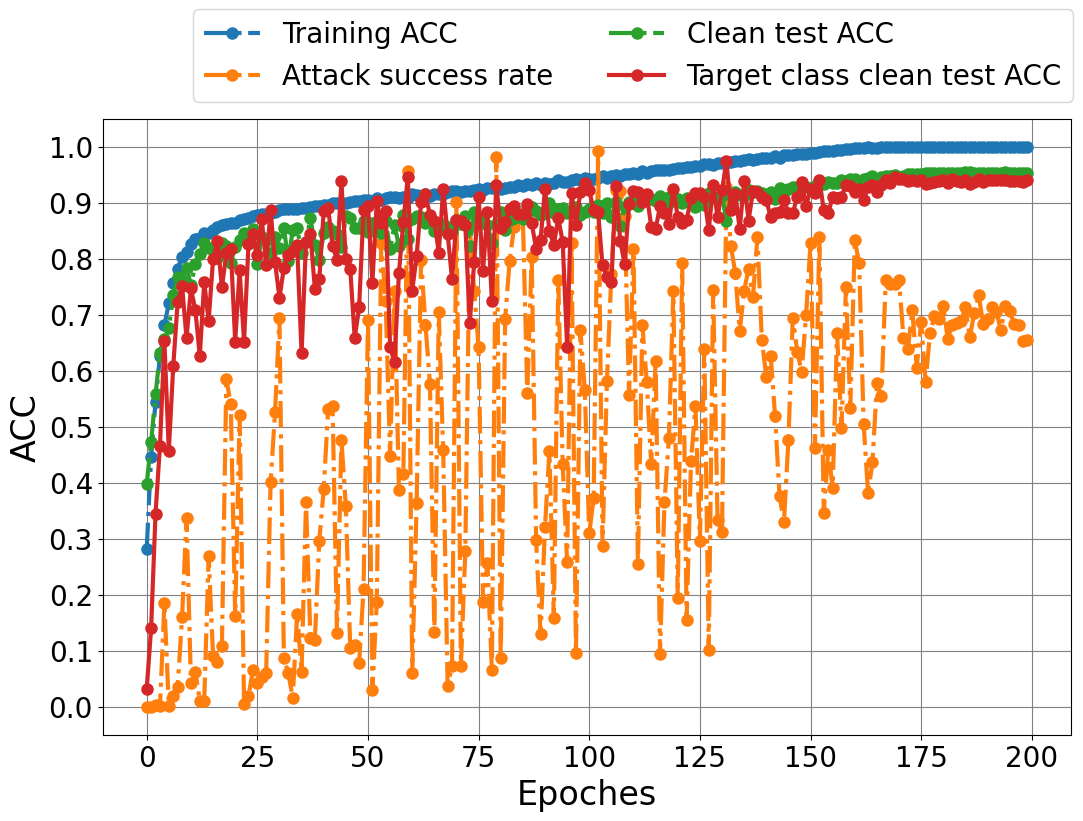

0.9999001996007985
attack 0.7137777777777777
185
all class clean 0.954
target clean 0.94


In [31]:
#cell 27
#ours -- higher_configureations
from matplotlib import pyplot as plt
half = np.arange(0,training_epochs)
plt.figure(figsize=(12.5,8))
plt.plot(half, np.asarray(train_ACC)[half], label='Training ACC', linestyle="-.", marker="o", linewidth=3.0, markersize = 8)
plt.plot(half, np.asarray(test_ACC)[half], label='Attack success rate', linestyle="-.", marker="o", linewidth=3.0, markersize = 8)
plt.plot(half, np.asarray(clean_ACC)[half], label='Clean test ACC', linestyle="-.", marker="o", linewidth=3.0, markersize = 8)
plt.plot(half, np.asarray(target_ACC)[half], label='Target class clean test ACC', linestyle="-", marker="o", linewidth=3.0, markersize = 8)
# plt.plot(half, np.asarray(test_unl_ACC)[half], label='protected test ACC', linestyle="-.", marker="o", linewidth=3.0, markersize = 8)
plt.ylabel('ACC', fontsize=24)
plt.xticks(fontsize=20)
plt.xlabel('Epoches', fontsize=24)
plt.yticks(np.arange(0,1.1, 0.1),fontsize=20)
plt.legend(fontsize=20,bbox_to_anchor=(1.016, 1.2),ncol=2)
plt.grid(color="gray", linestyle="-")
plt.show()

dis_idx = clean_ACC.index(max(clean_ACC))
print(train_ACC[dis_idx])
print('attack',test_ACC[dis_idx])
print(clean_ACC.index(max(clean_ACC)))
print('all class clean', clean_ACC[dis_idx])
print('target clean',target_ACC[dis_idx])

In [32]:
import json

metrics = {
    "train_ACC": train_ACC,
    "test_ACC": test_ACC,
    "clean_ACC": clean_ACC,
    "target_ACC": target_ACC
}

with open("metrics_adaptive_trigger20.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved training and evaluation metrics to metrics_adaptive_trigger.json")

Saved training and evaluation metrics to metrics_adaptive_trigger.json
